In [1]:
import pandas as pd
import random
from collections import Counter 
import operator
import math
import mmh3
import numpy as np
import time
import matplotlib.pylab as plt
plt.style.use('Solarize_Light2')
import sys
from functools import reduce
import seaborn as sns

%matplotlib inline


In [2]:
data_file = 'capture20110818.pcap.netflow.labeled' # scenario 10

In [3]:
infected_host = '147.32.84.165'
columns=['Date','Duration','Protocol','SrcIP', 'srcPort','DstIP', 'DstPort', 'Flags', 'TOS', 'Packets', 'Bytes', 'Label']
infected_lst= list()
uninfected_lst = list()
with open(data_file) as fp:
    for cnt, line in enumerate(fp):
        if cnt!=0:
            index = 0
            data = line.split("\t")
            data = list(filter(None, data)) 
            date = data[index]
            try:
                duration = data[index + 1]
            except:
                data = line.split(" ")
                data = list(filter(None, data)) 
                date = data[0] + " " + data[1]
                index = 1
                duration = data[index + 1]
            protocol = data[index + 2]
            src = data[index + 3].split(':')
            if len(src) < 2: # Set port to 0 if no port provided
                src.append(0)
            dst = data[index + 5].split(':')
            if len(dst) < 2:
                dst.append(0)
            flags = data[index + 6]
            tos = data[index + 7]
            packets = int(data[index + 8])
            byteno = float(data[index + 9])
            flows = data[index + 10]
            label = data[index + 11].rstrip()
#             if (src[0] == dst[0]):
#                 print("CONNECT TO SELF")
            if (src[0] != infected_host and dst[0] != infected_host):
                uninfected_lst.append([date, duration, protocol, src[0], src[1], dst[0], dst[1], flags, tos, packets, byteno, label])
            else:
                infected_lst.append([date, duration, protocol, src[0], src[1], dst[0], dst[1], flags, tos, packets, byteno, label])
            
infected_df = pd.DataFrame(infected_lst, columns=columns)
uninfected_df = pd.DataFrame(uninfected_lst, columns=columns)
infected_df.head()

del infected_lst
del uninfected_lst

In [4]:
uninfected_df.Label.value_counts()

Background    4535493
LEGITIMATE     321917
Botnet         293915
Name: Label, dtype: int64

In [5]:
# uninfected_df.apply(apply_is_botnet, axis=1)
uninfected_df['is_botnet'] = uninfected_df['Label'] == 'Botnet'
uninfected_df['is_botnet'].value_counts()

False    4857410
True      293915
Name: is_botnet, dtype: int64

In [6]:
uninfected_df.drop('Label', axis=1, inplace=True)
uninfected_df.columns


Index(['Date', 'Duration', 'Protocol', 'SrcIP', 'srcPort', 'DstIP', 'DstPort',
       'Flags', 'TOS', 'Packets', 'Bytes', 'is_botnet'],
      dtype='object')

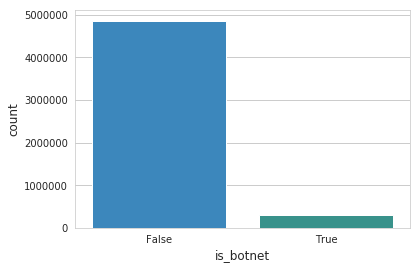

In [7]:
sns.set_style("whitegrid")
sns.countplot(x="is_botnet", data=uninfected_df)
plt.savefig('is_botnet_counts.png')

In [8]:
def cat_to_oneh(dataframe, column, hashsize):
    """
    Function for changing a column with categorical variables into multiple one hot encoded columns using hashes
    """
    df1 = dataframe[column].copy()
    print(len(df1))
    df1 = df1.apply(lambda x: str(hash(x))[1:hashsize])
    df1 = pd.DataFrame(df1.str.split('').tolist())
    df1 = df1.drop([0, hashsize], axis=1)
    df1 = pd.get_dummies(df1)
    df1.columns = [column + '_' + x for x in df1.columns]
    df1.reset_index(inplace=True, drop=True)
    return df1

cat_cols = ['Protocol']
col_amounts = [0,1,0,1,0,0,0]
uninfected_df.reset_index(inplace=True, drop=True)
index = 0
for col in cat_cols:
    if col_amounts[index]:
        uninfected_df = pd.concat([uninfected_df, cat_to_oneh(uninfected_df, col, 6)], axis=1)
    else:
        uninfected_df = pd.concat([uninfected_df, pd.get_dummies(uninfected_df[col])], axis=1)
    index += 1
    uninfected_df.drop(col, axis=1, inplace=True)
    


In [9]:
# Define some methods to perform the analysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

def split_data(x, y):
    values_to_predict = np.array(y)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(
        x, values_to_predict, test_size = 0.25, random_state = 42)
    
    return train_features, test_features, train_labels, test_labels

def random_forrest(train_features, test_features, train_labels, test_labels):
    rf = RandomForestClassifier(n_estimators = 10, random_state = 10, class_weight="balanced")
    # Train the model on training data
    rf.fit(train_features, train_labels);
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    # Calculate the absolute errors
#     errors = abs(predictions - test_labels)
    return predictions#, errors

from sklearn.metrics import confusion_matrix
def plot_roc_curve(fpr, tpr):  
    plt.figure(figsize=(12,8), dpi=300)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    return plt

def get_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f'True Neg: {tn}, False pos: {fp}, False neg: {fn}, True pos: {tp}')
    return (tn, fp, fn, tp)

In [10]:
# Drop some columns and set the rest to nummerical.
processed_df = uninfected_df.drop("Flags", axis=1).drop("Date", axis=1)
processed_df_withIPs = processed_df.copy()
processed_df = processed_df.drop("SrcIP", axis=1).drop("DstIP", axis=1)

# del uninfected_df
del infected_df

processed_df["Duration"] = pd.to_numeric(processed_df["Duration"])
processed_df["srcPort"] = pd.to_numeric(processed_df["srcPort"], errors='coerce')
processed_df["DstPort"] = pd.to_numeric(processed_df["DstPort"])
processed_df["TOS"] = pd.to_numeric(processed_df["TOS"])
processed_df = processed_df.dropna()
botnet_rows = processed_df['is_botnet']
processed_df = processed_df.drop("is_botnet", axis=1)


In [11]:
train_features, test_features, train_labels, test_labels = split_data(processed_df, botnet_rows)

In [12]:
train_features.columns

Index(['Duration', 'srcPort', 'DstPort', 'TOS', 'Packets', 'Bytes', 'ARP',
       'ESP', 'ICMP', 'IGMP', 'IPV6', 'IPV6-ICMP', 'IPX/SPX', 'LLC', 'PIM',
       'RTCP', 'RTP', 'TCP', 'UDP', 'UDT'],
      dtype='object')

True Neg: 1214309, False pos: 150, False neg: 234, True pos: 73088
AUC: 1.00


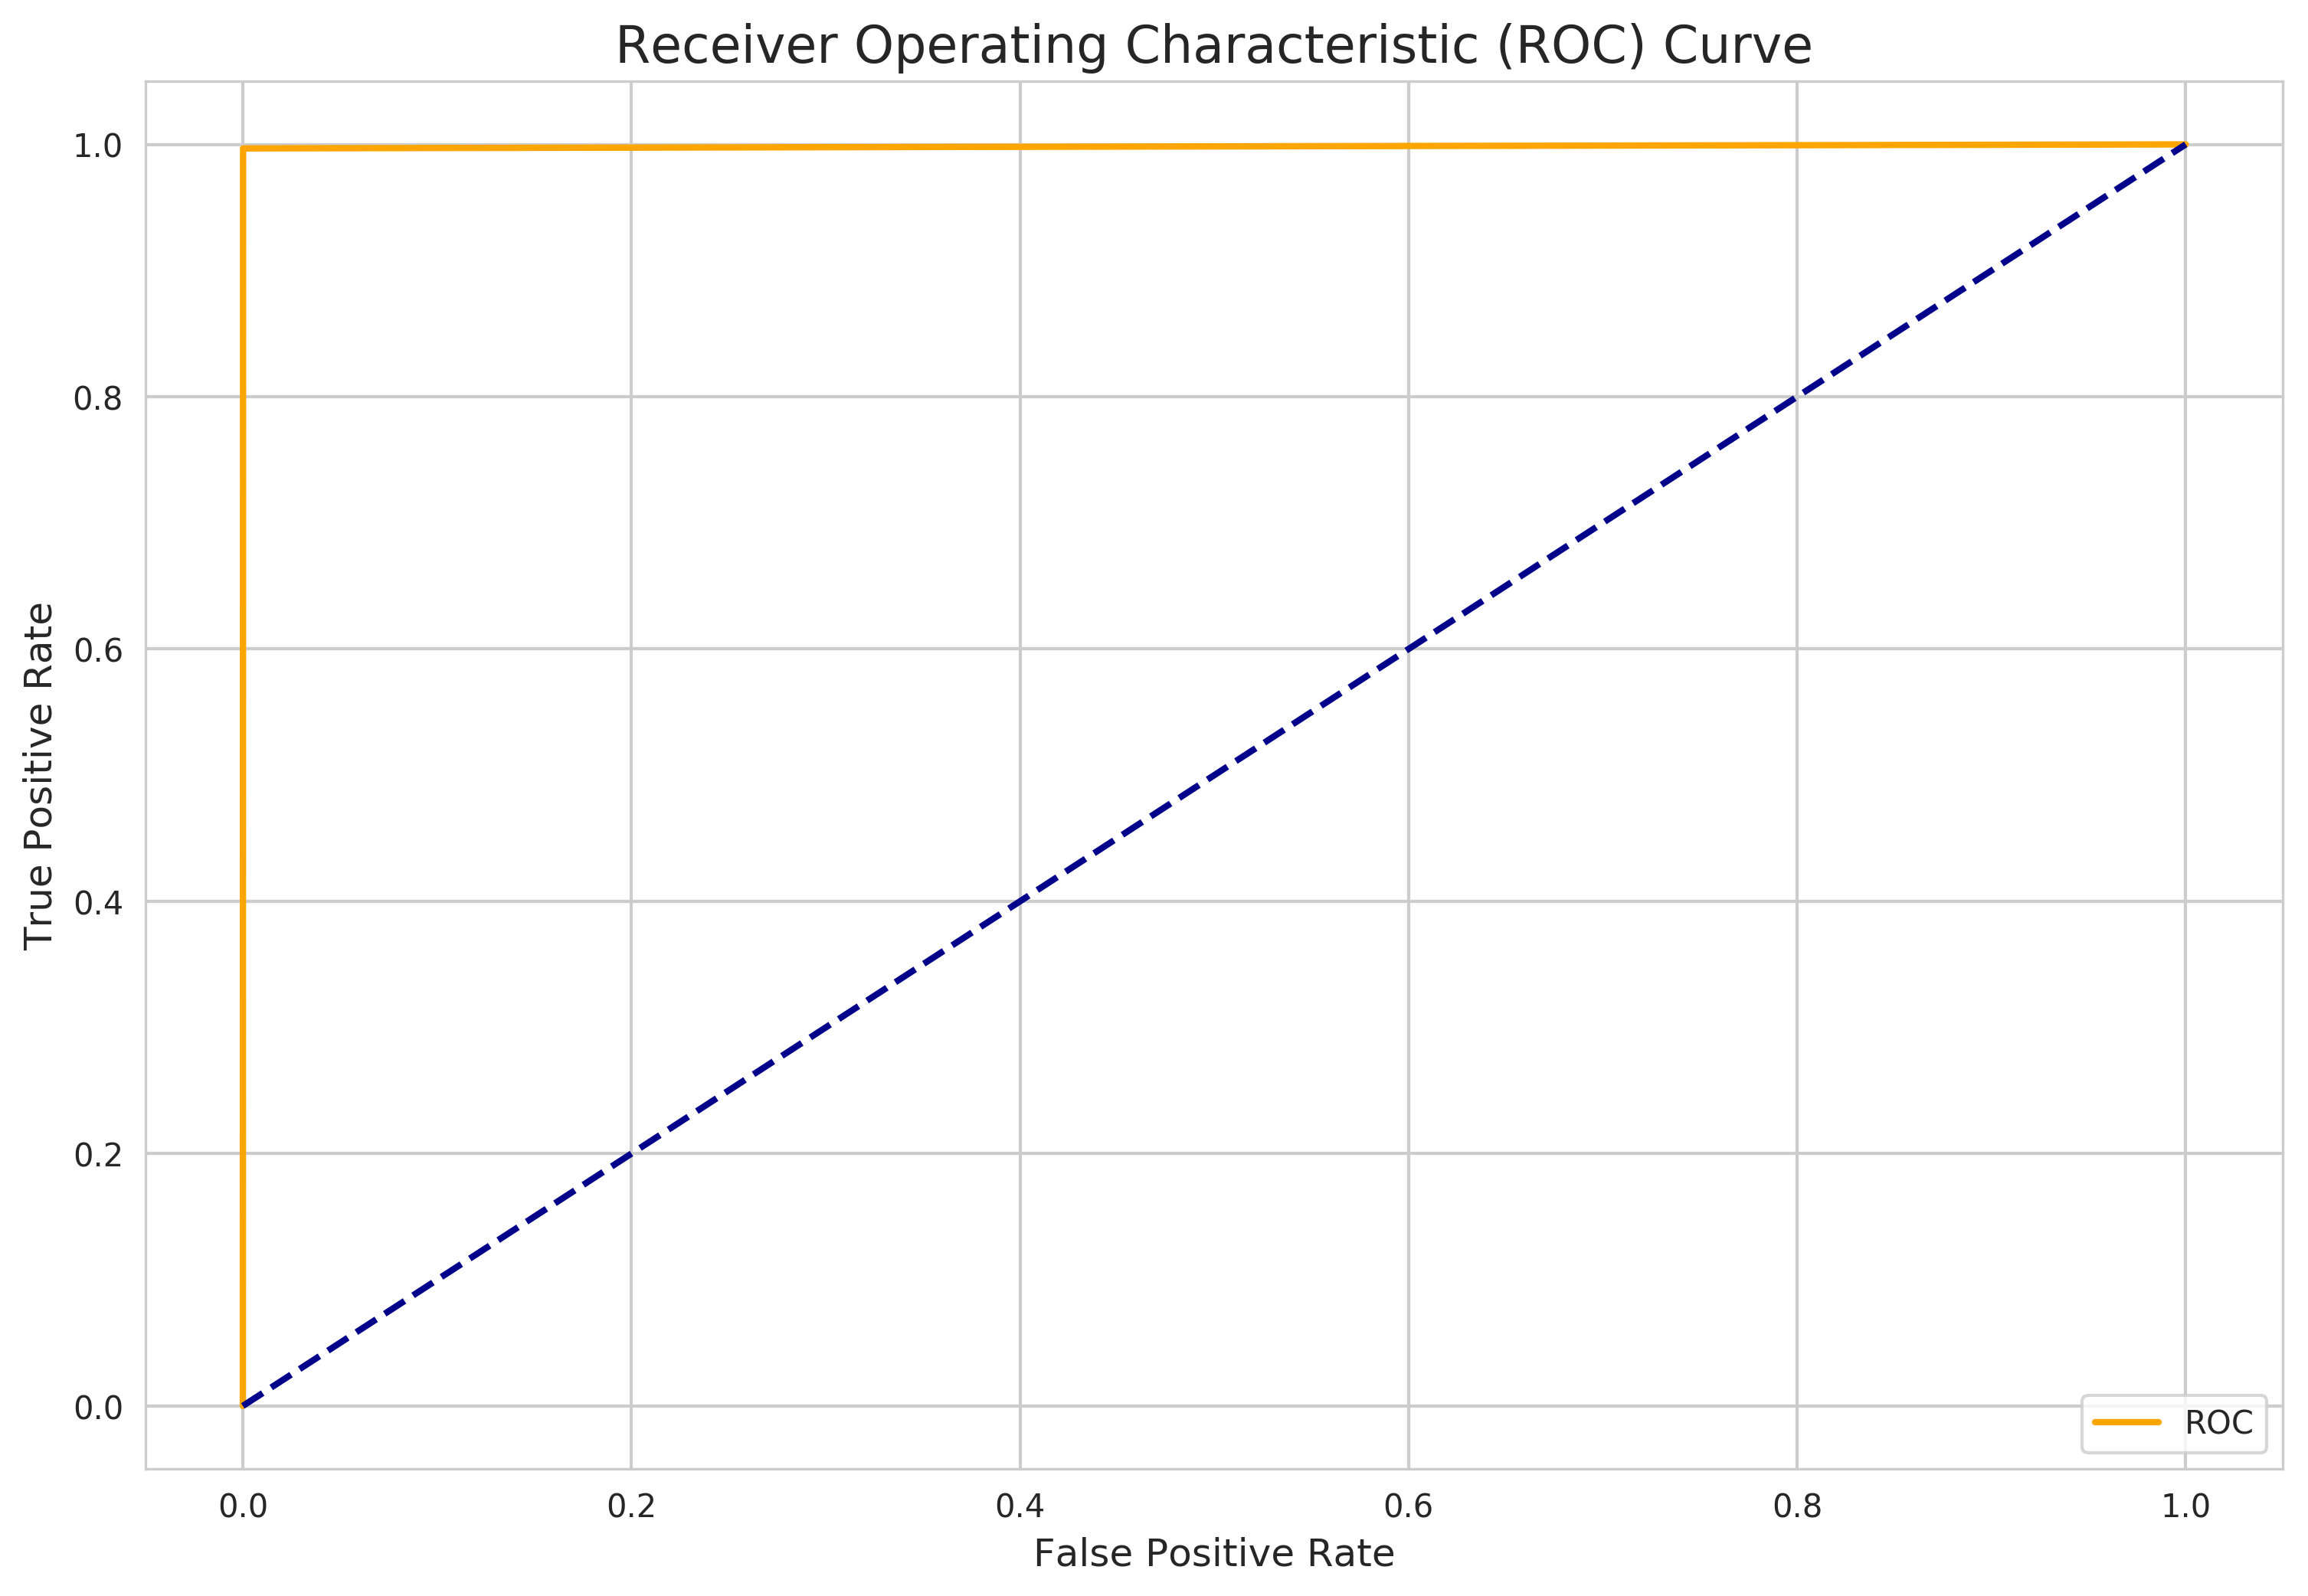

In [13]:
predictions = random_forrest(train_features, test_features, train_labels, test_labels)

pred = [round(x) for x in predictions]
get_metric(test_labels, predictions)
auc = roc_auc_score(test_labels, predictions)  
print('AUC: %.2f' % auc)  
fpr, tpr, thresholds = roc_curve(test_labels, predictions)  
plot_roc_curve(fpr, tpr).show()

In [14]:
acc= accuracy_score(predictions,test_labels)*100
f1= f1_score(predictions,test_labels)*100
rec= recall_score(predictions,test_labels)*100
prec=precision_score(predictions,test_labels)*100
print("Accuracy:","%.2f" % acc)
print("Precision:","%.2f" % prec)
print("Recall:", "%.2f" %rec)
print("F_score:","%.2f" % f1)

Accuracy: 99.97
Precision: 99.68
Recall: 99.80
F_score: 99.74


### Run Host based classification 50 times

In [15]:
from imblearn.over_sampling import SMOTE

new_dataset2=processed_df_withIPs.groupby('SrcIP')
new_dataset2=new_dataset2.sum()
new_dataset2=new_dataset2.reset_index()

#Assign labels
def label(data):
    infected=['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
             '147.32.84.205','147.32.84.206','147.32.84.207','147.32.84.208','147.32.84.209']
    return data in infected

new_dataset2['Label']=new_dataset2['SrcIP'].apply(lambda y: label(y))
final_dataset_host = new_dataset2.drop('SrcIP', axis=1)
botnet_labels = final_dataset_host["Label"]
print(final_dataset_host.Label.value_counts())
final_dataset_host = final_dataset_host.drop("Label", axis=1)

TN = []
FP = [] 
FN = [] 
TP = []
ACC = []
F1 = []
REC = []
PREC = []
for i in range(50):
    try:
        classifier=RandomForestClassifier(n_estimators=100)
        
        X_train, X_test, y_train, y_test = train_test_split(final_dataset_host, botnet_labels, test_size=0.2)
        while not np.any(y_train) or not np.any(y_test):
            # Demand at least one positive case in both train AND test sets
            # If this is not the case, split again
            X_train, X_test, y_train, y_test = train_test_split(final_dataset_host, botnet_labels, test_size=0.2)
        
        smt=SMOTE(ratio=0.5)
        new_X_train, new_y_train=smt.fit_sample(X_train,y_train)
        classifier.fit(new_X_train, new_y_train)
        predictions=classifier.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(predictions,y_test,labels=[False,True]).ravel()
        
        TN.append(tn)
        FP.append(fp)
        TP.append(tp)
        FN.append(fn)
        acc= accuracy_score(predictions,y_test)*100
        ACC.append(acc)
        f1= f1_score(predictions,y_test)*100
        F1.append(f1)
        rec= recall_score(predictions,y_test)*100
        REC.append(rec)
        prec=precision_score(predictions,y_test)*100
        PREC.append(prec)
    except:
        pass

print('')
print('True Negative',np.sum(TN))
print('False Positive',np.sum(FP))
print('False Negative',np.sum(FN))
print('True Positive',np.sum(TP))
print('-------------')
print('Precision :', np.mean(PREC))
print('Recall : ', np.mean(REC))
print('Accuracy : ',np.mean(ACC))

/usr/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


False    185112
True          9
Name: Label, dtype: int64

True Negative 1666032
False Positive 0
False Negative 10
True Positive 83
-------------
Precision : 100.0
Recall :  91.85185185185185
Accuracy :  99.9993998049366


### Below does the same but just one pass

In [16]:
from imblearn.over_sampling import SMOTE

new_dataset2=processed_df_withIPs.groupby('SrcIP')
new_dataset2=new_dataset2.sum()
new_dataset2=new_dataset2.reset_index()

#Assign labels
def label(data):
    infected=['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
             '147.32.84.205','147.32.84.206','147.32.84.207','147.32.84.208','147.32.84.209']
    return data in infected

new_dataset2['Label']=new_dataset2['SrcIP'].apply(lambda y: label(y))
final_dataset_host = new_dataset2.drop('SrcIP', axis=1)
botnet_labels = final_dataset_host["Label"]
print(final_dataset_host.Label.value_counts())

final_dataset_host = final_dataset_host.drop("Label", axis=1)

classifier=RandomForestClassifier(n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(final_dataset_host, botnet_labels, test_size=0.2)

smt=SMOTE(ratio=float(0.5))
new_X_train, new_y_train=smt.fit_sample(X_train,y_train)
classifier.fit(new_X_train, new_y_train)
predictions=classifier.predict(X_test)
tn, fp, fn, tp = confusion_matrix(predictions,y_test,labels=[False,True]).ravel()
print(f'True Neg: {tn}, False pos: {fp}, False neg: {fn}, True pos: {tp}')

acc= accuracy_score(predictions,y_test)*100
f1= f1_score(predictions,y_test)*100
rec= recall_score(predictions,y_test)*100
prec=precision_score(predictions,y_test)*100
print("Accuracy:","%.2f" % acc)
print("Precision:","%.2f" % prec)
print("Recall:", "%.2f" %rec)
print("F_score:","%.2f" % f1)

False    185112
True          9
Name: Label, dtype: int64
True Neg: 37023, False pos: 0, False neg: 1, True pos: 1
Accuracy: 100.00
Precision: 100.00
Recall: 50.00
F_score: 66.67
